In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tfk = tf.keras
tfkl = tf.keras.layers

(512, 512, 512)


Text(0.5, 1.0, 'Lagrangian Density pre re-ion')

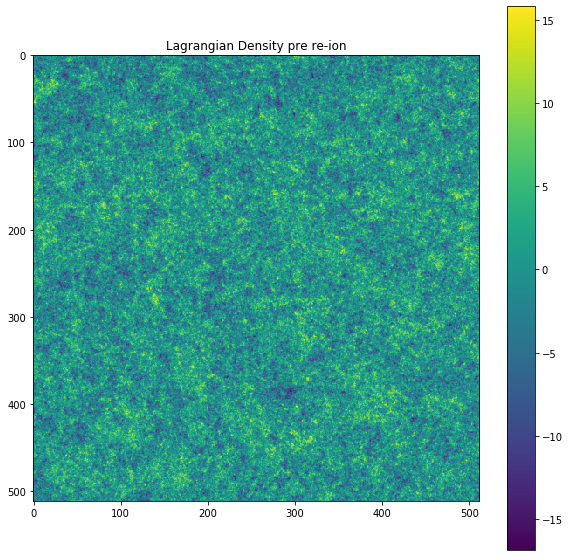

In [3]:
N = 512
datadir = '/global/cscratch1/sd/tmedan/notebooks/'

freion = open(datadir+'reionization/reion_06')
fdensL  = open(datadir+'density_Lag/dens_06')
fdensE  = open(datadir+'density_Eul/dens_06')

densL = np.fromfile(fdensL, count=N**3, dtype=np.float32).reshape(N,N,N)
densE = np.fromfile(fdensE, count=N**3, dtype=np.float32).reshape(N,N,N)
reion = np.fromfile(freion, count=N**3, dtype=np.float32).reshape(N,N,N)


print(densL.shape)
plt.figure(figsize = (10,10))
plt.imshow(densL[0])
plt.colorbar()
plt.title('Lagrangian Density pre re-ion')

In [4]:

class ScaleField(): #this is just utilizing storing the max min and average values of 
    #the strict data set!
    # used min-max scaling HERE ONLY 
    def __init__(self, field):
        super(ScaleField, self).__init__()

        self.fmin  = field.min()
        self.fmax  = field.max() 
        self.fmean = field.mean()
    
    def scale(self, field, inv=False): 
        if not inv:
            self.scaled = True
            return (field - self.fmin) / (self.fmax - self.fmin)
        if inv:
            self.scaled = False
            return field * (self.fmax - self.fmin) + self.fmin
            
density_scalingL = ScaleField(densL)
density_scalingE = ScaleField(densE)
reionization_scaling = ScaleField(reion)

densL = density_scalingL.scale(field=densL)
densE = density_scalingE.scale(field=densE)
reion = reionization_scaling.scale(field=reion)

print(densL.shape)

(512, 512, 512)


In [5]:
def cubify(arr, newshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    oldshape = np.array(arr.shape)
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.column_stack([repeats, newshape]).ravel()
    order = np.arange(len(tmpshape))
    order = np.concatenate([order[::2], order[1::2]])
    
    # newshape must divide oldshape evenly or else ValueError will be raised
    return arr.reshape(tmpshape).transpose(order).reshape(-1, *newshape)

def uncubify(arr, oldshape):
    '''stolen from https://stackoverflow.com/questions/42297115/numpy-split-cube-into-cubes'''
    N, newshape = arr.shape[0], arr.shape[1:]
    oldshape = np.array(oldshape)    
    repeats = (oldshape / newshape).astype(int)
    tmpshape = np.concatenate([repeats, newshape])
    order = np.arange(len(tmpshape)).reshape(2, -1).ravel(order='F')
    return arr.reshape(tmpshape).transpose(order).reshape(oldshape)

In [6]:
n_filters = 36

img_shape = 32

Input_shape=(img_shape,img_shape,img_shape,1)

model = tfk.Sequential()
    
model.add(tfkl.Conv3D(filters=n_filters,
                     kernel_size=(5,5,5),
                     strides=(1,1,1),
                     use_bias=True,
                     input_shape=Input_shape,
                      padding = 'same'))
model.add(tfkl.BatchNormalization())
model.add(tfkl.Activation('relu'))

model.add(tfkl.Conv3D(filters=n_filters,
                     kernel_size=(3,3,3),
                     strides=(1,1,1),
                     use_bias=True,
                     input_shape=Input_shape,
                      padding = 'same'))
model.add(tfkl.BatchNormalization())
model.add(tfkl.Activation('relu'))

model.add(tfkl.Conv3D(filters=n_filters,
                     kernel_size=(3,3,3),
                     strides=(1,1,1),
                     use_bias=True,
                     input_shape=Input_shape,
                      padding = 'same'))
model.add(tfkl.BatchNormalization())
model.add(tfkl.LeakyReLU(alpha = 0.3))

model.add(tfkl.Conv3D(filters=n_filters,
                     kernel_size=(1,1,1),
                     strides=(1,1,1),
                     use_bias=True,
                     input_shape=Input_shape,
                      padding = 'same'))
model.add(tfkl.BatchNormalization())
model.add(tfkl.LeakyReLU(alpha = 0.3))

model.add(tfkl.Conv3D(filters=1,
                     kernel_size=(1,1,1),
                     strides=(1,1,1),
                     use_bias=False,padding= 'same'))
model.add(tfkl.Activation('relu'))

model.summary()
print(len(model.layers))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 32, 32, 32, 36)    4536      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32, 36)    144       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32, 36)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 32, 32, 32, 36)    35028     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32, 36)    144       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32, 36)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 32, 32, 32, 36)    3

(4096, 32, 32, 32, 1)


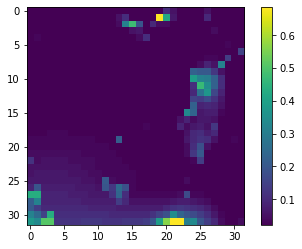

In [7]:
#training data

densL_train = cubify(densL,(img_shape,img_shape,img_shape))[..., np.newaxis]

reion_train = cubify(reion,(img_shape,img_shape,img_shape))[..., np.newaxis]

densE_train = cubify(densE,(img_shape,img_shape,img_shape))[...,np.newaxis]

print(reion_train.shape)

plt.figure()
plt.imshow(reion_train[0,0,...,0])
plt.colorbar()

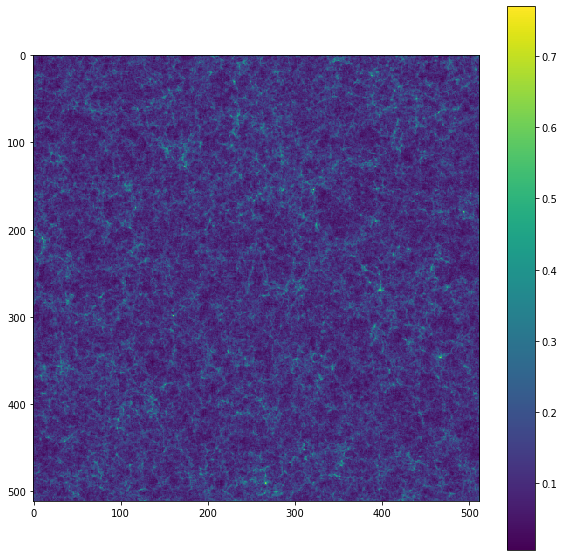

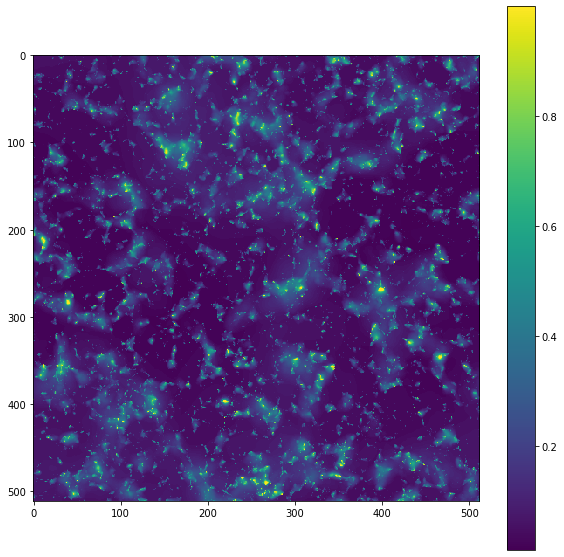

In [8]:
# get test data
freion = open(datadir+'reionization/reion_07')
fdens  = open(datadir+'density_Eul/dens_07')

x_test  = np.fromfile(fdens, count=N**3, dtype=np.float32).reshape(N,N,N)
y_test  = np.fromfile(freion, count=N**3, dtype=np.float32).reshape(N,N,N)

# density_scaling_test      = ScaleField(x_test)
# reionization_scaling_test = ScaleField(y_test)

x_test = density_scalingE.scale(field=x_test)
y_test = reionization_scaling.scale(field=y_test)


plt.figure(figsize=(10,10))
plt.imshow(x_test[0])
plt.colorbar()

plt.figure(figsize=(10,10))
plt.imshow(y_test[0])
plt.colorbar()

x_test = cubify(x_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]
y_test = cubify(y_test,  (img_shape, img_shape, img_shape))[..., np.newaxis]


reion_test         = reionization_scaling.scale(field=y_test, inv=True)

In [9]:
optimizer = tfk.optimizers.Adam(1e-2)
model.compile(optimizer=optimizer, loss='mse',metrics=['mae'])

history = model.fit(densE_train,reion_train,
                   epochs=50,
                   validation_split = 0.1,
                   verbose=1)

Epoch 1/50
116/116 [==============================] - 14s 119ms/step - loss: 0.0281 - mae: 0.0944 - val_loss: 0.0170 - val_mae: 0.0940
Epoch 2/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0088 - mae: 0.0684 - val_loss: 0.0243 - val_mae: 0.1052
Epoch 3/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0063 - mae: 0.0586 - val_loss: 0.0110 - val_mae: 0.0700
Epoch 4/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0057 - mae: 0.0555 - val_loss: 0.0155 - val_mae: 0.0795
Epoch 5/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0050 - mae: 0.0520 - val_loss: 0.0090 - val_mae: 0.0640
Epoch 6/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0046 - mae: 0.0491 - val_loss: 0.0055 - val_mae: 0.0523
Epoch 7/50
116/116 [==============================] - 13s 115ms/step - loss: 0.0043 - mae: 0.0473 - val_loss: 0.0057 - val_mae: 0.0531
Epoch 8/50
116/116 [==============================] - 1

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


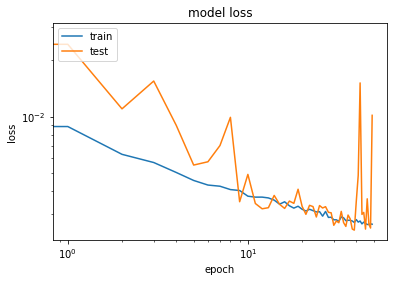

In [10]:

print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.xscale('log')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('5_layer_CNN_scaled_trainplot')
plt.show()

In [11]:

y_test_predict = model.predict(x_test)

reion_test_predict = reionization_scaling.scale(field=y_test_predict, inv=True)

In [12]:

yshow_predict = reion_test_predict[0,img_shape//2, ..., 0]
yshow = reion_test[0,img_shape//2, ..., 0]
xshow = x_test[0,img_shape//2, ..., 0]

ymin = yshow.min()
ymax = yshow.max()

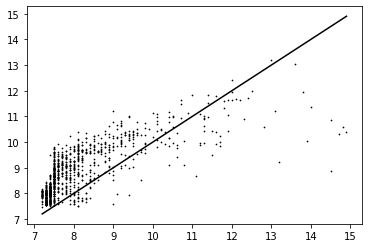

In [13]:

plt.scatter(yshow.flatten(),yshow_predict.flatten(),c='k',s=0.5)
xx = np.linspace(yshow.min(), yshow.max(), 100)
plt.plot(xx,xx, 'k')

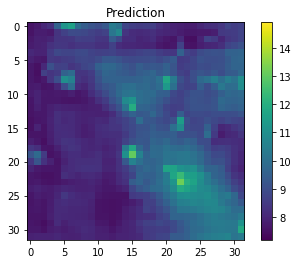

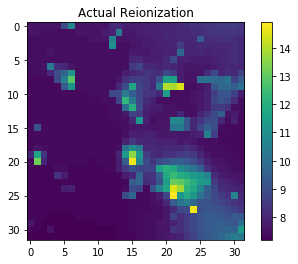

In [16]:
plt.figure()
plt.imshow(yshow_predict,vmin=ymin, vmax=ymax)
plt.title('Prediction')
plt.savefig('5_layer_CNN_scaled_predict')
plt.colorbar()


plt.figure()
plt.imshow(yshow)
plt.title('Actual Reionization')
plt.savefig('5_layer_CNN_scaled_actual')
plt.colorbar()


# plt.figure()
# plt.imshow(yshow_predict,vmin = ymin, vmax = ymax)
# plt.colorbar()